# Gaussian bump potential 1 - background plots and power spectrum

This is the first in a series of notebooks which will run importance sampling for the Gaussian bump potential. It is commended the reading is familair with
- [Importance sampling](https://arxiv.org/abs/2206.11234).
- How to simulate the linear Sasaki-Mukhanov mode equation in inflation. 
- The [PyFPT user guides](https://github.com/Jacks0nJ/PyFPT/tree/main/User%20guides).

These Notebooks are simply meant to make all of the 2D results reproducible and are minimal in details.

In this notebook the background dynamics will be simulated and the power spectrum found.

Throughout natural units with $c = 8\pi M_{\rm PL} = \hbar =1$ are used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mystyle
plt.style.use(mystyle.paper_style)

from scipy.interpolate import CubicSpline
from scipy.integrate import odeint
from scipy.integrate import RK45
from scipy.optimize import root
from scipy.integrate import quad
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from timeit import default_timer as timer

## The potential
This is the [Gaussian bump potential](https://arxiv.org/abs/1911.00057).

In [2]:
def potential(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction = (phi**2)/(m_squared + phi**2)
    return V_0*fraction*(1 + K*expo)

def potential_functional_form(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction = (phi**2)/(m_squared + phi**2)
    return fraction*(1 + K*expo)

def potential_dif(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction1 = (phi**2)/(m_squared + phi**2)
    fraction2 = (phi)/(m_squared + phi**2) - (phi**3)/((m_squared + phi**2)**2)
    
    term1 = 2*V_0*fraction2*(1 + K*expo)
    term2 = V_0*fraction1*(-K*expo*(phi-phi_0)/(sigma_tilde**2))
    return term1 + term2

# I tested this against an interpolation of my previous derivative
def potential_ddif(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    square_brackets = 1 + K*expo
    overall_factor = 2*V_0/(m_squared + phi**2)
    
    term1 = -2*potential_dif(phi)*phi/(m_squared + phi**2)
    term2 = overall_factor*(1 - 3*(phi**2)/(m_squared + phi**2) + 2*(phi**4)/((m_squared + phi**2)**2))*\
        (1 + K*expo)
    term3 = overall_factor*(phi - (phi**3)/(m_squared + phi**2))*(-K*(phi-phi_0)*expo/(sigma_tilde**2))
    term4 = -overall_factor*0.5*phi*K*(3*phi - 2*phi_0)*expo/(sigma_tilde**2)
    term5 = overall_factor*0.5*K*expo*(phi*(phi-phi_0)/(sigma_tilde**2))**2
    
    return term1 + term2 + term3 + term4 + term5

def V_prime_by_V(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction3 = 1/phi - (phi)/(m_squared + phi**2)
    fraction4 = -(phi-phi_0)/(sigma_tilde**2)
    
    term1 = 2*fraction3
    term2 = fraction4*K*expo/(1 + K*expo)
    return term1 + term2

The parameters are shown such that the power spectrum peaks at $5 \times 10^{-3}$ in the astroid mass gap.

In [3]:
K = 1.17*(10**-3)  # This needs all 3 sig fig
cmb_power = 2*10**-9
cmb_phi = 3.0
phi_0 = 2.18812
m = 0.5
m_squared = m**2
sigma_tilde = 1.59*(10**-2)

V_0 = 12*(np.pi**2)*(cmb_power/potential_functional_form(cmb_phi))*(V_prime_by_V(cmb_phi)**2)

Let's plot this

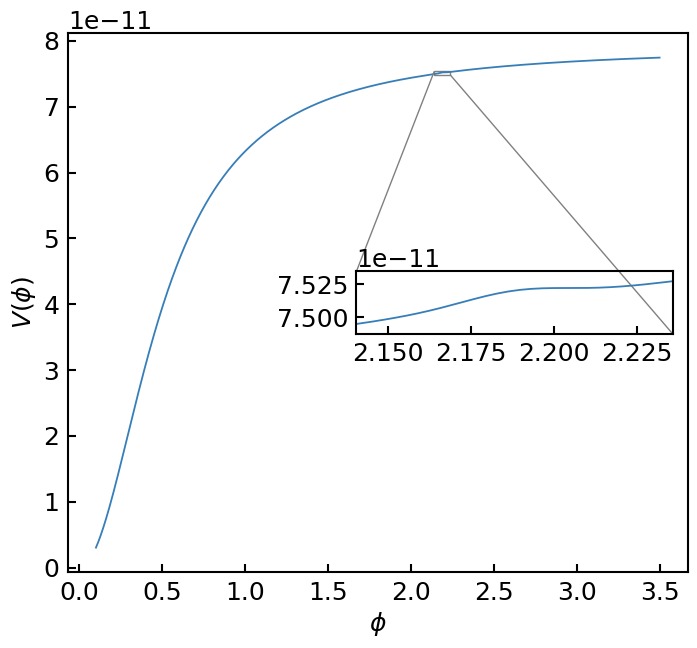

<Figure size 800x520 with 0 Axes>

In [4]:
phi_values = np.linspace(0.1, 3.5, 1000)
V_values = potential(phi_values)

small_phi = 3*sigma_tilde
fig = plt.figure(figsize = [8., 7.])
ax = plt.axes()
ax.plot(phi_values, V_values)
axins = zoomed_inset_axes(ax, 20, loc=7) # zoom = 2
axins.plot(phi_values, V_values)
axins.set_xlim(phi_0 - small_phi, phi_0 + small_phi)
axins.set_ylim(0.999*potential(phi_0 - small_phi), 1.001*potential(phi_0 + small_phi))
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$V(\phi)$")
plt.show()
plt.clf()

# Background simulation
Let's simulate background dynamics starting on CMB scales until the end of inflation using a Runge-Kutta 45 method

In [5]:
def klien_gordon(N, vec):
    phi, pi = vec
    dpi_by_dN = -(3 - 0.5*pi**2)*(pi + V_prime_by_V(phi))
    return [pi, dpi_by_dN]

Let's use slow roll at NLO to set the initial conditions with maximum accuracy.

We need second derivative of the potential, where I will do it numerically

In [6]:
phi_values = np.linspace(0.1, 3.5, 1000)
V_dif_values = potential_dif(phi_values)
V_dif_interpolation = CubicSpline(phi_values, V_dif_values)

In [7]:
def hubble_param_LO_1(phi):
    return 0.5*(potential_dif(phi)/potential(phi))**2

def hubble_param_LO_2(phi):
    return 2*( (potential_dif(phi)/potential(phi))**2\
              - V_dif_interpolation(phi, 1)/potential(phi) )

def hubble_param_NLO_1(phi):
    return hubble_param_LO_1(phi)*(1 - hubble_param_LO_2(phi)/3)

def dpi_by_dN_NLO(phi):
    return -(2*hubble_param_NLO_1(phi))**0.5

Now simulate the background

In [8]:
phi_in_start = cmb_phi
dpi_by_dN_in_start  = dpi_by_dN_NLO(phi_in_start)
initial_state = [phi_in_start , dpi_by_dN_in_start]

# Step through the simulations
N_values = []
phi_values = []
phi_diff_values = []
solution_background = RK45(klien_gordon, 0, initial_state, 57, rtol=10**-12, atol=10**-15)


# Step through the simulations
while solution_background.status != 'finished':
    solution_background.step()
    N_values.append(solution_background.t)
    phi_values.append(solution_background.y[0])
    phi_diff_values.append(solution_background.y[1])

N_values = np.array(N_values)
phi_values = np.array(phi_values)
phi_diff_values = np.array(phi_diff_values)

sol = np.zeros((len(N_values), 2))
sol[:, 0] = phi_values
sol[:, 1] = phi_diff_values

Now we have the general sim, now let's find when it should end and re-simulate, ending at that value.

In [9]:
def hubble_param_1_func(dpi_by_dN):
    return (dpi_by_dN**2)/2 

def hubble_func(phi, pi):
    H_squared = 2*potential(phi)/(6-pi**2)
    return H_squared**0.5

def hubble_param_2_func(phi, pi):
    epsilon_H = hubble_param_1_func(pi)
    V_prime_by_V_value =  V_prime_by_V(phi)
    return 2*epsilon_H - V_prime_by_V_value*(6-pi**2)/pi - 6

In [10]:
def nu_sqaured_func(N):
    epsilon2 = epsilon2_interpolation(N, 0)
    epsilon1 = epsilon1_interpolation(N, 0)
    epsilon2_derivative = epsilon2_interpolation(N, 1)
    return 9/4 - epsilon1 + (3/2)*epsilon2 - (1/2)*epsilon1*epsilon2 + (epsilon2**2)/4\
        + epsilon2_derivative/2

In [11]:
hubble_param_values = np.array([hubble_func(sol[i, 0], sol[i, 1]) for i in range(len(sol[:, 0]))])
epsilon1_values = np.array([hubble_param_1_func(dpi_by_dN) for dpi_by_dN in sol[:, 1]])
epsilon2_values = np.array([hubble_param_2_func(sol[i, 0], sol[i, 1]) for i in range(len(sol[:, 0]))])

# interpolation
hubble_param_interpolation = CubicSpline(N_values, hubble_param_values)
epsilon1_interpolation = CubicSpline(N_values, epsilon1_values)
epsilon2_interpolation = CubicSpline(N_values, epsilon2_values)

In [12]:
epsilon1_values[-1]

2.2688430896289513

So this simulated ended after inflation ended. Let's use it to find when inflation actually ended, and then re-simulate

In [13]:
from scipy.interpolate import interp1d
N_interpolate = interp1d(epsilon1_values, N_values)
N_end = N_interpolate(1)
print("N end")
print(N_end)
phi_interpolate = interp1d(epsilon1_values, phi_values)
phi_end = phi_interpolate(1)
print("phi end")
print(phi_end)

N end
56.8826959159262
phi end
0.35826387061478066


Let's resimulate up to this point

In [14]:
# Step through the simulations
N_values = []
phi_values = []
phi_diff_values = []
solution_background = RK45(klien_gordon, 0, initial_state, N_end, rtol=10**-12, atol=10**-15)


# Step through the simulations
while solution_background.status != 'finished':
    solution_background.step()
    N_values.append(solution_background.t)
    phi_values.append(solution_background.y[0])
    phi_diff_values.append(solution_background.y[1])

N_values = np.array(N_values)
phi_values = np.array(phi_values)
phi_diff_values = np.array(phi_diff_values)

sol = np.zeros((len(N_values), 2))
sol[:, 0] = phi_values
sol[:, 1] = phi_diff_values

In [15]:
print("phi end")
phi_end = phi_values[-1]
print(phi_end)

phi end
0.3582680276468886


Now let's interpolate over these new values

In [16]:
hubble_param_values = np.array([hubble_func(sol[i, 0], sol[i, 1]) for i in range(len(sol[:, 0]))])
epsilon1_values = np.array([hubble_param_1_func(dpi_by_dN) for dpi_by_dN in sol[:, 1]])
epsilon2_values = np.array([hubble_param_2_func(sol[i, 0], sol[i, 1]) for i in range(len(sol[:, 0]))])

# interpolation
hubble_param_interpolation = CubicSpline(N_values, hubble_param_values)
epsilon1_interpolation = CubicSpline(N_values, epsilon1_values)
epsilon2_interpolation = CubicSpline(N_values, epsilon2_values)

In [17]:
nu_squared_values = np.array([nu_sqaured_func(N_values[i]) for i in range(len(N_values))])

nu_squared_interpolation = CubicSpline(N_values, nu_squared_values)

In [18]:
N_for_plotting_logic = (N_values>25) & (N_values<N_end-4)

Now let's plot what the Hubble flow parameters and $\nu^2$ is doing

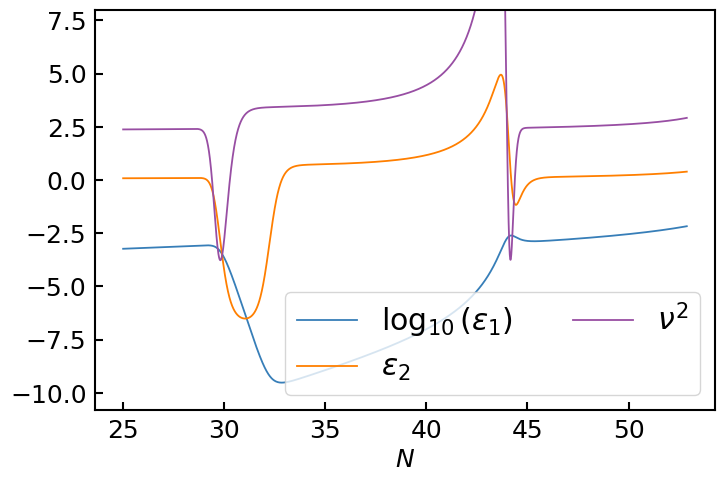

<Figure size 800x520 with 0 Axes>

In [19]:
epsilon_H_values = np.array([hubble_param_1_func(dpi_by_dN) for dpi_by_dN in sol[:, 1]])

plt.plot(N_values[N_for_plotting_logic], np.log10(epsilon_H_values[N_for_plotting_logic]),
         label=r"$\log_{10}{(\epsilon_{1})}$")
plt.plot(N_values[N_for_plotting_logic], epsilon2_values[N_for_plotting_logic], label=r"$\epsilon_{2}$")
plt.plot(N_values[N_for_plotting_logic], nu_squared_values[N_for_plotting_logic], label=r"$\nu^2$")
plt.xlabel(r"$N$")
plt.ylim(top=8)
plt.legend(ncol=2)
plt.show()
plt.clf()

While there is clearly a period of ultra-slow roll, what is its precise duration? Let's find out using standard root-finding techniques and interpolation.

In [20]:
def root_finding_epsilon2(N_guess, epsilon2_chosen=-3):
    def epsilon2_value_diff(N_epsilon2_time):
        return epsilon2_interpolation(N_epsilon2_time) - epsilon2_chosen
    sol_epsilon2_time = root(epsilon2_value_diff, N_guess)
    N_epsilon2_time = sol_epsilon2_time.x
    return float(N_epsilon2_time)

In [21]:
N_usr_start_guess = N_values[epsilon2_values<-3][0]
N_usr_end_guess = N_values[epsilon2_values<-3][-1]

N_usr_start = root_finding_epsilon2(N_usr_start_guess)
N_usr_end = root_finding_epsilon2(N_usr_end_guess)

print("Ultra-slow roll started at")
print(N_usr_start)
print("and ended at")
print(N_usr_end)

Ultra-slow roll started at
29.84178346243688
and ended at
32.25059795813168


### Now let's save this 

In [22]:
data_dict = {}
data_dict["N"] = N_values
data_dict["phi"] = phi_values
data_dict["phi_N_diff"] = phi_diff_values
data_dict["H"] = hubble_param_values
data_dict["epsilon1"] = epsilon1_values
data_dict["epsilon2"] = epsilon2_values
data_dict["nu_squared"] = nu_squared_values

data_pandas = pd.DataFrame(data_dict)

data_pandas.to_csv("gaussian_bump_dynamics_dynamics"+".csv")

## Mode simulation

To find the power spectrum, we need to be able to simulare a linear mode from deep inside the horizon until Hubble-crossing until the end of inflation. Below are the required functions for the comoving curvature perturbation $\mathcal{R}$

In [23]:
def R_initial_condition_BD_with_phase(k, a_0, H_0, epsilon1_0, epsilon2_0, comoving_time):
    phase = np.exp(complex(0, -k*comoving_time))
    R0 = complex(np.divide(1, 2*a_0*(epsilon1_0*k)**0.5), 0)*phase
    R_derivative_0 = -complex(1 + 0.5*epsilon2_0, k/(a_0*H_0))*R0
    return R0, R_derivative_0 

def R_mode_equation(N, vec):
    R, d_R_by_dN = vec
    epsilon1 = epsilon1_interpolation(N)
    epsilon2 = epsilon2_interpolation(N)
    aH = aH_interpolation(N)
    d2_R_by_dN2 = -complex(3 - epsilon1 + epsilon2, 0)*d_R_by_dN - R*(k/(aH))**2
    return [d_R_by_dN, d2_R_by_dN2]

In [24]:
def comoving_time_func(N_interest, N_end):
    def comoving_time_integrand(N):
        aH = aH_interpolation(N)
        return 1/aH
    comoving_time_value, _ = quad(comoving_time_integrand, N_end, N_interest, limit=1000)
    return comoving_time_value

In [25]:
def find_cg_time(k, sigma, N_exit):
    def exit_time_func(N_rc_exit):
        return k - sigma*aH_interpolation(N_rc_exit)
    N_guess = N_exit + np.log(sigma**-1)
    sol_rc_time = root(exit_time_func, N_guess)
    N_rc_exit = sol_rc_time.x
    return float(N_rc_exit)

In [26]:
def run_mode_sim(N_exit):

    N_time_to_horizon = 6.
    N_starting = N_exit - N_time_to_horizon

    H_0 = hubble_param_interpolation(N_starting)
    epsilon1_0 = epsilon1_interpolation(N_starting)
    epsilon2_0 = epsilon2_interpolation(N_starting)
    a_0 = a_interpolation(N_starting)

    k = aH_interpolation(N_exit)

    comoving_time_0 = comoving_time_func(N_starting, N_end)

    N_values_R_sim = []
    R_values = []
    R_diff_values = []

    R_0, d_R_by_dN_0 = R_initial_condition_BD_with_phase(k, a_0, H_0, epsilon1_0, epsilon2_0, comoving_time_0)
    initial_state_R = [R_0, d_R_by_dN_0]
    solution_R = RK45(R_mode_equation, N_starting, initial_state_R, N_end, rtol=10**-11, atol=10**-14)

    # Only need to do 1 simulation
    while solution_R.status != 'finished':
        solution_R.step()
        N_values_R_sim.append(solution_R.t)
        R_values.append(solution_R.y[0])
        R_diff_values.append(solution_R.y[1])
    N_values_R_sim = np.array(N_values_R_sim)
    R_values = np.array(R_values)
    R_diff_values = np.array(R_diff_values)
    return N_values_R_sim, R_values, R_diff_values

Now let's test it for a mode near the CMB scale to make sure it has the correct overall amplitude

In [27]:
# Overall scale factor
a_in = 1.

In [28]:
# Need to normalise the scale factor, this is so reasonable numbers are always used in the numerics.
# If an an overall normalisation is done, then errors can occur from needing to store very large or small
# numbers.

N_exit = 7
aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_exit))
a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_exit))

k = aH_interpolation(N_exit)

N_values_R_sim, R_values, R_diff_values = run_mode_sim(N_exit)

In [29]:
R_rescaled_values = R_values*(k**3/(2*np.pi**2))**0.5

In [30]:
np.abs(R_rescaled_values[-1])**2

1.5944606528160838e-09

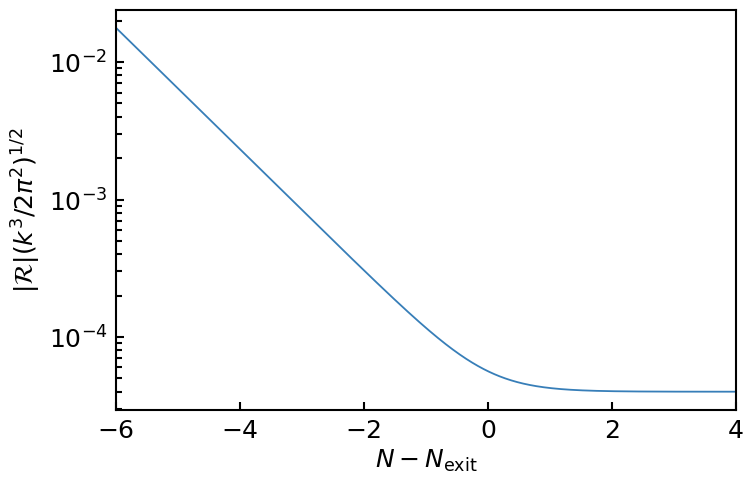

<Figure size 800x520 with 0 Axes>

In [31]:
plt.plot(N_values_R_sim-N_exit, np.abs(R_rescaled_values))
plt.yscale("log")
plt.xlim(left=-6, right=4)
plt.ylabel(r"$|\mathcal{R}| (k^3/2\pi^2)^{1/2}$")
plt.xlabel(r"$N - N_{\rm exit}$")
plt.show()
plt.clf()

Correct!

# Power spectrum

To obtain the power spectrum, we need to run many such mode simulations. This is done with the code. Only the value at certian $\sigma$ values and the end of inflation is kept.

In [32]:
from scipy.integrate import RK45
from timeit import default_timer as timer
# Define the when the modes left and find their scale
# Define the time when the different modes are coarse-grained

sigma_values = np.array([1.0, 0.5, 0.1, 0.01])
N_time_to_horizon = 6.

# Remember to give time for super horizon evolution
N_modes = np.linspace(N_usr_start-9, N_usr_start+11, 600)

k_raw_values = np.zeros(len(N_modes))

R_at_sigma_values = np.zeros((len(sigma_values), len(N_modes)), dtype="complex")
R_diff_at_sigma_values = np.zeros((len(sigma_values), len(N_modes)), dtype="complex")
R_end_values = np.zeros(len(N_modes), dtype="complex")

start_time = timer()

for i in range(len(N_modes)):
    N_exit = N_modes[i]
    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_exit))

    k = aH_interpolation(N_exit)

    N_values_R_sim, R_values, R_diff_values = run_mode_sim(N_exit)

    R_interp = interp1d(N_values_R_sim, R_values)
    R_diff_interp = interp1d(N_values_R_sim, R_diff_values)

    for j in range(len(sigma_values)):
        sigma = sigma_values[j]
        N_cg = find_cg_time(k, sigma, N_exit)
        R_cg = R_interp(N_cg)
        R_diff_cg = R_diff_interp(N_cg)

        R_at_sigma_values[j, i] = R_cg
        R_diff_at_sigma_values[j, i] = R_diff_cg

    # Storing
    k_raw_values[i] = k
    R_end_values[i] = R_values[-1]

    if (i%50)==0:
        end_time = timer()
        print(i)
        print("Taken "+str(end_time-start_time)+" so far")

0
Taken 3.942743946099654 so far
50
Taken 190.11771151900757 so far
100
Taken 375.9592401260743 so far
150
Taken 562.1504127900116 so far
200
Taken 746.8883698619902 so far
250
Taken 934.4148605500814 so far
300
Taken 1122.8168407930061 so far
350
Taken 1313.4340012359899 so far
400
Taken 1507.4999519620324 so far
450
Taken 1704.7447338360362 so far
500
Taken 1898.726762150065 so far
550
Taken 2093.7291814390337 so far


Now let's ca use these to find the power spectrum.

**It is important to store each $k$ value seperately, as each one has a different scale factor normalisation**

In [33]:
def power_spectrum_func(k, R):
    return (np.abs(R)**2)*(k**3)/(2*np.pi**2)

Now let's save these values

In [34]:
import pandas as pd

data_dict = {}
data_dict["N exit"] = N_modes
data_dict["k"] = k_raw_values
data_dict["R end"] = R_end_values
for j in range(len(sigma_values)):
    data_dict["R at sigma "+str(sigma_values[j])] = R_at_sigma_values[j,:]
    data_dict["R diff at sigma "+str(sigma_values[j])] = R_diff_at_sigma_values[j,:]

data_pandas = pd.DataFrame(data_dict)

data_pandas.to_csv("gaussian_bump_range_of_R_values_at_different_sigma"+".csv")

Now let's load this data back in

In [35]:
sigma_values = np.array([1.0, 0.5, 0.1, 0.01])

matching_data = pd.read_csv("gaussian_bump_range_of_R_values_at_different_sigma"+".csv", index_col=0)

N_modes = np.array(matching_data["N exit"])
k_raw_values = np.array(matching_data["k"])
R_end_values = np.array(matching_data["R end"],  dtype=np.complex64)


R_at_sigma_values = np.zeros((len(sigma_values), len(N_modes)), dtype="complex")
R_diff_at_sigma_values = np.zeros((len(sigma_values), len(N_modes)), dtype="complex")

for j in range(len(sigma_values)):
    R_at_sigma_values[j, :] = matching_data["R at sigma "+str(sigma_values[j])]
    R_diff_at_sigma_values[j, :] = matching_data["R diff at sigma "+str(sigma_values[j])]

Now let's also test it is giving me the correct final form

In [36]:
power_spectrum = power_spectrum_func(k_raw_values, R_end_values)
power_spectrum_at_sigma_001_new = power_spectrum_func(k_raw_values, R_at_sigma_values[-1, :])

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_usr_start))
a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_usr_start))

k_usr_start = aH_interpolation(N_usr_start)
k_usr_end = aH_interpolation(N_usr_end)

k_values_normalised = aH_interpolation(N_modes)/k_usr_start

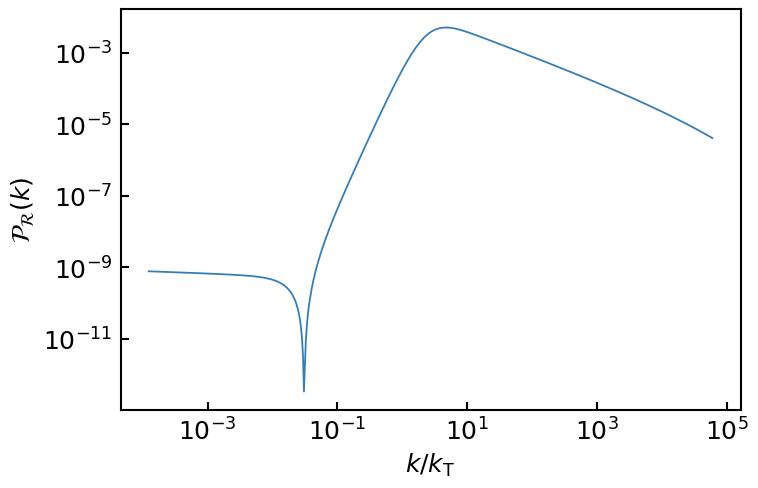

<Figure size 800x520 with 0 Axes>

In [37]:
plt.plot(k_values_normalised, power_spectrum)
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$\mathcal{P}_{\mathcal{R}}(k)$")
plt.xlabel(r"$k/k_{\rm T}$")
plt.show()
plt.clf()